<a href="https://colab.research.google.com/github/snoop2head/OIA_Text_Wrangling/blob/master/_Department_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
print(pd.__version__)
print(np.__version__)

1.1.4
1.17.2


In [364]:
file_name = "_department_t.csv"
path = "data/" + file_name
df = pd.read_csv(path)
# 데이터의 크기가 어느정도인지 본다.
df.shape

(141, 182)

In [365]:
df

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,181
0,Australian National University,Bond University,Curtin University of Technology,La Trobe University,Monash University,University of New South Wales,University of Queensland,University of Sydney,"University of Technology, Sydney",FH Kufstein Tirol University of Applied Sciences,...,University of Tennessee Knoxville,University of Texas at Arlington,University of Utah,University of Washington,University of Wisconsin-Madison,Washington College,Washington University in St. Louis,Western Kentucky University,Western Washington University,Westminster College
1,UD IS,경영학,경영학,경영학,UIC,GSIS,InformationandInteractionDesign,UD PSIR,UIC TAD,경영학,...,경영학,간호학,EESE,UD Economics,UIC,경영학,UD Economics,UD Economics,UD Economics,경영학
2,경영학,경제학,경제학,경영학,UIC,건축학,건축공학,UD CLC,건축공학,경영학,...,경영학,건축공학,경영학,UIC LSBT,UIC ASD,경영학,UIC ASD,건축공학,경영학,경영학
3,경제학,경제학,국어국문,교육학,경영학,경영학,경영학,UIC ASD,건축학,경영학,...,경영학,경영학,경영학,UD Economics,경영학,경영학,경영학,경영학,경영학,경영학
4,경제학,국어국문,사회학,교육학,경영학,경영학,경영학,UIC,건축학,경영학,...,경제학,경영학,경영학,UIC LSBT,경영학,경영학,경영학,경영학,경영학,경제학
5,경제학,기계공학,사회환경시스템공학,금속시스템공학,경영학,경영학,경영학,UIC,경영학,경영학,...,사회학대학,경영학,경영학,UD IS,경영학,교육/경제,경영학,경영학,경영학,노어노문
6,경제학/정치외교학,도시공학,사회환경시스템공학,물리치료학,경영학,경영학,경영학,UIC,경영학,경영학,...,사회복지학,경영학,경영학,건축공학,경영학,사학,경영학,경영학,경영학,디자인/심리학
7,노어노문,불어불문,생명공학,불어불문,경영학,경영학,경영학,건축공학,경영학,경영학,...,사회학,경영학,경영학,경영학,경영학,사학,경영학,경제학,사회복지학,생활디자인/언론홍보영상
8,대기학,사회복지학,생화학,불어불문,경영학,경영학,경제학,건축학,경영학,경영학,...,상경대학경제학,경영학,경영학,경영학,경영학,사회복지학,경영학,경제학,상경계열,신문방송학
9,문헌정보/경영학,상경계열,신학,생물학,경제학,경제학,경제학,경영학,경영학,경영학,...,세라믹공학,경영학,경제.수학,경영학,경영학,상경계열,경영학,교육학,생물학,신문방송학


In [384]:
def new_dataframe(data):
    df = []
    variances = []
    for i in data.columns:
        value = data[i][1:].value_counts().std()
        variances.append(value)
    university = []
    for i in data.columns:
        univ = data[i][0]
        university.append(univ)
    dept_count = []
    for i in data.columns:
        dept = len(data[i][1:].value_counts())
        dept_count.append(dept)
    std_count = []
    for i in data.columns:
        std = data[i][1:].value_counts().sum()
        std_count.append(std)
    df.append(university)
    df.append(dept_count)
    df.append(std_count)
    df.append(variances)
    df = pd.DataFrame(df).transpose()
    df.columns = ['university', 'dept_count', 'std_count', 'variances']
    return df
    

In [385]:
data = new_dataframe(df)

In [386]:
data

,university,dept_count,std_count,variances
0,Australian National University,18,24,0.594089
1,Bond University,14,19,0.633324
2,Curtin University of Technology,14,16,0.363137
3,La Trobe University,13,22,1.37747
4,Monash University,24,39,1.20911
5,University of New South Wales,25,42,1.28193
6,University of Queensland,35,57,1.43662
7,University of Sydney,26,45,1.6866
8,"University of Technology, Sydney",26,47,1.98029
9,FH Kufstein Tirol University of Applied Sciences,11,40,5.02539


In [387]:
df_new = data.drop(columns=['university'])

In [388]:
# 정규화
transformer = MinMaxScaler(feature_range=(0, 1))
transformer.fit(df_new)
x_data = transformer.transform(df_new)

In [389]:
pd.DataFrame(x_data, columns=['dept_count', 'std_count', 'variances']).corr()

,dept_count,std_count,variances
dept_count,1.000000,0.902943,-0.067051
std_count,0.902943,1.000000,0.313187
variances,-0.067051,0.313187,1.000000


/Users/gunwook/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7ffab3c12090>,
                 k=None, model=None)

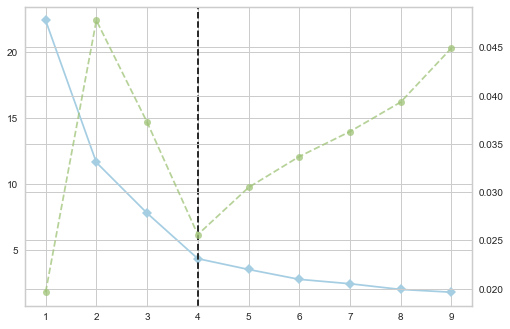

In [390]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(x_data)

In [391]:
# 4개 군집으로 진행
model = KMeans(n_clusters=4, random_state=307)
model.fit(x_data)

KMeans(n_clusters=4, random_state=307)

In [392]:
# 1번 그룹: 특정 전공의 편향도가 높은 그룹, 그리고 학생이 적음
# 2번 그룹: 전공의 편향도가 낮은 그룹, 학생수가 많음
# 3번 그룹: 전공의 편향도가 낮은 그룹, 학생수가 어느정도 있음
# 4번 그룹: 특정 전공의 편향도가 높은 그룹, 학생 수는 적음
cluster_mean = pd.DataFrame(model.cluster_centers_, columns=['variance', 'no_of_students', 'no_of_departments'])
cluster_mean

,variance,no_of_students,no_of_departments
0,0.193665,0.082306,0.090141
1,0.836923,0.971774,0.260355
2,0.424329,0.390285,0.186173
3,0.130484,0.202808,0.513767


In [413]:
data[data['category'] == 1]

,university,dept_count,std_count,variances,category
17,University of British Columbia,48,137,4.71751,1
141,SUNY at Albany,45,140,5.7494,1
148,University of California Berkeley,63,140,2.73829,1
149,University of California Davis,68,140,1.93847,1
150,University of California Irvine,56,140,3.50584,1
151,University of California Los Angeles,64,140,2.30854,1
153,University of California San Diego,61,140,3.44647,1
154,University of California Santa Barbara,68,140,2.21179,1
159,University of Illinois at Urbana-Champaign,48,109,2.9154,1
175,University of Washington,53,139,6.01353,1


In [393]:
data['category'] = model.labels_

In [394]:
data['category'].value_counts()

0    102
2     43
3     27
1     10
Name: category, dtype: int64

In [395]:
pca = PCA(n_components=2)
pca_fit = pca.fit(x_data)

In [396]:
pca_result = pd.DataFrame(data=pca.fit_transform(x_data))

In [397]:
pca_result['category'] = model.labels_

In [398]:
pca_result

,0,1,category
0,-0.175924,-0.150493,0
1,-0.243598,-0.129151,0
2,-0.266212,-0.151420,0
3,-0.224071,-0.065636,0
4,-0.017898,-0.126954,0
5,0.011271,-0.124979,0
6,0.199647,-0.157686,2
7,0.044602,-0.097867,2
8,0.061102,-0.074419,2
9,-0.081033,0.232191,3


In [399]:
pca_result = pca_result.rename(columns={0:'pca1', 1:'pca2'})

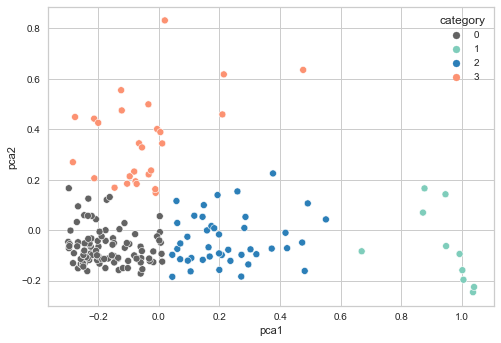

In [404]:
sns.scatterplot(data=pca_result, x='pca1', y='pca2', hue='category', palette=['#636363', '#7fcdbb', '#2c7fb8', '#fc9272'])